In [ ]:
import os, time, math
import torch
import torch.nn.functional as F
from PIL import Image
import numpy as np
import torchvision.transforms as T

# Configure
ROOT_DIR = r"D:\DepthEstimate"
PSMNET_DIR = os.path.join(ROOT_DIR, "stereo", "PSMNet")
CHECKPOINT = os.path.join(PSMNET_DIR, "checkpoint", "pretrained_sceneflow_new.tar")
LEFT_IMG = r"/conten/image_3/0001.png"
RIGHT_IMG = r"/content/image_2/0001.png"
SAVE_DIR = os.path.join(ROOT_DIR, "runs_out", "PSMNet_CPU")
os.makedirs(SAVE_DIR, exist_ok=True)

MAX_DISP = 192
DEVICE = torch.device("cpu")  # ép dùng CPU


import sys
sys.path.insert(0, PSMNET_DIR)
from models.stackhourglass import PSMNet

# ==== Load image util ====
norm = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def load_image(path):
    img = Image.open(path).convert('RGB')
    t = T.ToTensor()(img)
    t = norm(t)
    _, H, W = t.shape
    pad = (0, (math.ceil(W/16)*16 - W), math.ceil(H/16)*16 - H, 0)
    t = F.pad(t, pad)
    return t.unsqueeze(0), pad

def unpad_disp(disp, pad):
    left, right, top, bottom = pad
    if disp.ndim == 3 and disp.shape[0] == 1:
        disp = disp[0]
    H, W = disp.shape
    return disp[top:, :W-right]

def save_disparity_png16(disp, path_png16):
    img16 = (disp * 256.0).clip(0, 65535).astype(np.uint16)
    Image.fromarray(img16).save(path_png16)

# Load model
model = PSMNet(MAX_DISP)
ckpt = torch.load(CHECKPOINT, map_location="cpu")
state = ckpt["state_dict"] if "state_dict" in ckpt else ckpt
# loại bỏ prefix "module." nếu có
state = {k.replace("module.", ""): v for k, v in state.items()}
model.load_state_dict(state, strict=False)
model = model.to(DEVICE).eval()

print("[Info] Model loaded on CPU")

# Inference
L, padL = load_image(LEFT_IMG)
R, padR = load_image(RIGHT_IMG)
L, R = L.to(DEVICE), R.to(DEVICE)

print("[Info] Running inference...")
t0 = time.time()
with torch.no_grad():
    disp = model(L, R)
t1 = time.time()

disp = torch.squeeze(disp, 0).cpu().numpy()
disp = unpad_disp(disp, padL)

print(f"[Done] Inference finished in {t1-t0:.2f}s, disp range=({disp.min():.2f}, {disp.max():.2f})")

# ==== Save result ====
stem = os.path.splitext(os.path.basename(LEFT_IMG))[0]
out_png = os.path.join(SAVE_DIR, f"{stem}_disp16.png")
save_disparity_png16(disp, out_png)
print(f"Saved disparity map → {out_png}")


[Info] Model loaded on CPU ✅
[Info] Running inference...
[Done] Inference finished in 8.30s, disp range=(1.22, 189.79)
Saved disparity map → D:\DepthEstimate\runs_out\PSMNet_CPU\0001_disp16.png


In [ ]:
# Optional: Convert disparity -> depth (Z = f * B / d)
import cv2

# --- camera parameters ---
FOCAL_PIX = 721.5377     # ví dụ: KITTI camera 0
BASELINE_M = 0.54        # baseline 54 cm (KITTI default)

def disparity_to_depth(disp, focal_pix, baseline_m):
    """Convert disparity (px) to depth (m)."""
    disp_safe = np.where(disp > 0, disp, np.nan)
    depth = (focal_pix * baseline_m) / disp_safe
    return depth


In [ ]:
# optional: depth
if FOCAL_PIX > 0 and BASELINE_M > 0:
    depth_m = disparity_to_depth(disp, FOCAL_PIX, BASELINE_M)
    out_depth_npy   = os.path.join(SAVE_DIR, f"{stem}_depth_m.npy")
    out_depth_mm16  = os.path.join(SAVE_DIR, f"{stem}_depth_mm16.png")
    np.save(out_depth_npy, depth_m.astype(np.float32))
    mm16 = np.clip(depth_m*1000.0, 0, 65535).astype(np.uint16)
    cv2.imwrite(out_depth_mm16, mm16)
    print("Saved:", out_depth_npy, "and", out_depth_mm16)

Saved: D:\DepthEstimate\runs_out\PSMNet_CPU\0001_depth_m.npy and D:\DepthEstimate\runs_out\PSMNet_CPU\0001_depth_mm16.png


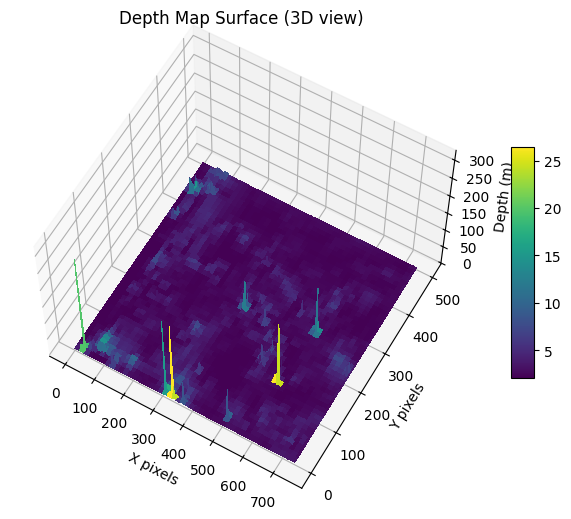

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # cần để kích hoạt 3D projection

# depth map
pred = depth_m
H, W = pred.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# display
surf = ax.plot_surface(X, Y, pred, cmap='viridis', linewidth=0, antialiased=False)
ax.set_title("Depth Map Surface (3D view)")
ax.set_xlabel("X pixels")
ax.set_ylabel("Y pixels")
ax.set_zlabel("Depth (m)")

# 3D
ax.view_init(elev=60, azim=-60)

# color
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Feature(nn.Module):
    def __init__(self, c=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, c, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(c, c, 3, 2, 1), nn.ReLU(True),
            nn.Conv2d(c, c, 3, 1, 1), nn.ReLU(True),
        )

    def forward(self, x): return self.net(x)

class HourglassBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.down = nn.Conv3d(in_channels, in_channels*2, 3, 2, 1)
        self.up = nn.ConvTranspose3d(in_channels*2, in_channels, 3, 2, 1, output_padding=1)
        self.conv = nn.Conv3d(in_channels, in_channels, 3, 1, 1)

    def forward(self, x):
        down = self.down(x)
        up = self.up(down)
        return self.conv(x + up)

class Cost3D(nn.Module):
    def __init__(self, max_disp=48, c=32):  # Reduced to 48 < 64 (effective W after downsample)
        super().__init__()
        self.max_disp = max_disp
        self.agg = nn.Sequential(
            nn.Conv3d(2*c, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv3d(32, 32, 3, 1, 1), nn.ReLU(True),
            nn.Conv3d(32, 1, 3, 1, 1)
        )
        self.hourglass = HourglassBlock(1)

    def forward(self, fL, fR):
        B, C, H, W = fL.shape
        costs = []
        for d in range(self.max_disp):
            if d > 0:
                cL = fL[:, :, :, d:]
                cR = fR[:, :, :, :-d]
            else:
                cL = fL; cR = fR
            costs.append(torch.cat([F.pad(cL, (0, d, 0, 0)), F.pad(cR, (d, 0, 0, 0))], 1))
        cost = torch.stack(costs, dim=1)  # B x D x 2C x H x W
        cost = cost.permute(0, 2, 1, 3, 4)  # B x 2C x D x H x W
        out = self.agg(cost).squeeze(1)  # B x D x H x W
        out = self.hourglass(out.unsqueeze(1)).squeeze(1)

        prob = F.softmax(-out, dim=1)
        disp_soft = torch.sum(prob * torch.arange(self.max_disp, device=prob.device)[None, :, None, None], dim=1)

        disp_hard = torch.argmax(-out, dim=1).float()

        return disp_soft, disp_hard

class MiniPSM(nn.Module):
    def __init__(self, max_disp=48, c=32):
        super().__init__()
        self.feat = Feature(c)
        self.cost = Cost3D(max_disp, c)

    def forward(self, L, R):
        fL = self.feat(L); fR = self.feat(R)
        return self.cost(fL, fR)

if __name__ == "__main__":
    model = MiniPSM()
    L = torch.rand(1, 3, 64, 128)
    R = torch.rand(1, 3, 64, 128)
    disp_soft, disp_hard = model(L, R)
    print("Disp soft shape:", disp_soft.shape)
    print("Disp hard shape:", disp_hard.shape)
    print("Difference mean:", torch.mean(torch.abs(disp_soft - disp_hard)))

Disp soft shape: torch.Size([1, 32, 64])
Disp hard shape: torch.Size([1, 32, 64])
Difference mean: tensor(20.3428, grad_fn=<MeanBackward0>)
